# General examples of los calculations

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sympy.printing.pretty.pretty_symbology import line_width

# Setup time new roman font for plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Computational burden

The computational burden is the average slope of the simulation time vs execution time.

In general, the simulation time is equally spaced according to some step size $\delta t$.

The execution time, instead, might vary across different runs due to underlying hardware, software, etc.

In [27]:
# Simulation time
sim_time = np.linspace(0, 60, 100)

# Execution time realizations
n_real = 50
exec_time = np.zeros((n_real, len(sim_time)))
for i in range(n_real):
    for j in range(1, len(sim_time)):
        increment = np.random.uniform(0.5, 2.0)
        exec_time[i, j] = exec_time[i, j-1] + increment

In [28]:
from greyboxmodels.voi.metrics.computational_load import computational_load

# Computational load
slopes = [computational_load(sim_time, exec_time[i, :]) for i in range(n_real)]
comp_load = np.mean(slopes)

eff_curve = comp_load * sim_time

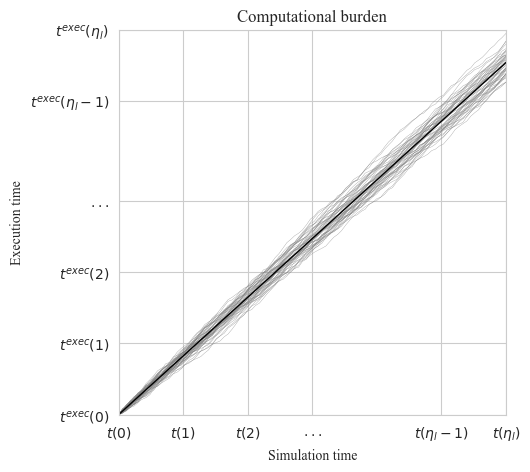

In [36]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in range(n_real):
    ax.plot(sim_time, exec_time[i, :], linewidth=0.2, color='gray')

ax.plot(sim_time, eff_curve, linewidth=1, color='black', label=f'$L_1$ = {comp_load:.2f}')

ax.set_xlabel('Simulation time')
ax.set_ylabel('Execution time')
ax.set_xlim([0, 60])
ax.set_ylim([0, 135])
ax.set_title('Computational burden')

# Modify the ticks. First, x-axis
x_pos = [0, 10, 20, 30, 50, 60]
x_label = ["$t(0)$", "$t(1)$", "$t(2)$", "$...$", "$t(\eta_l-1)$", "$t(\eta_l)$"]
ax.set_xticks(x_pos)
ax.set_xticklabels(x_label)

# Second, y-axis
y_pos = [0, 25, 50, 75, 110, 135]
y_label = ["$t^{exec}(0)$", "$t^{exec}(1)$", "$t^{exec}(2)$", "$...$", "$t^{exec}(\eta_l-1)$", "$t^{exec}(\eta_l)$"]
ax.set_yticks(y_pos)
ax.set_yticklabels(y_label)
None

## Fidelity

The fidelity is the time-averaged Kolmogorov-Smirnov distance between the ground truth and the model predictions.

For each time step, we have a pdf for the ground truth and a pdf for the model predictions.

Then, we calculate the Kolmogorov-Smirnov distance between the two distributions for each time step.

Finally, we average the distances across all time steps.

In [143]:
sim_time = np.linspace(0, 10, 100)

In [144]:
def dummy_model(t, p0, p1, p2, n_samples=500):
    X = np.zeros((n_samples, len(t)))
    # X[:, 0] = p0 * np.ones(n_samples)
    X[:, 1] = p0 * np.ones(n_samples)
    for i in range(2, len(t)):
        X[:, i] = X[:, i-1] + p1 * X[:, i-2] + np.random.normal(0, p2, n_samples)

    return X


In [145]:
np.random.seed(42)
n_samples = 1000

# ground truth distributions
p0_gt = np.random.uniform(0.8, 1.2)
p1_gt = np.random.uniform(-1.0, -0.8)
p2_gt = np.random.uniform(0.001, 0.003)
ground_truth = dummy_model(sim_time, p0_gt, p1_gt, p2_gt, n_samples=n_samples)

print(p0_gt, p1_gt, p2_gt)

# Two models
p0_model1 = 1.0
p1_model1 = -0.9
p2_model1 = 0.002
model_predictions1 = dummy_model(sim_time, p0_model1, p1_model1, p2_model1, n_samples=n_samples)

p0_model2 = 0.95
p1_model2 = -0.85
p2_model2 = 0.0026
model_predictions2 = dummy_model(sim_time, p0_model2, p1_model2, p2_model2, n_samples=n_samples)

0.949816047538945 -0.8098571387180168 0.0024639878836228103


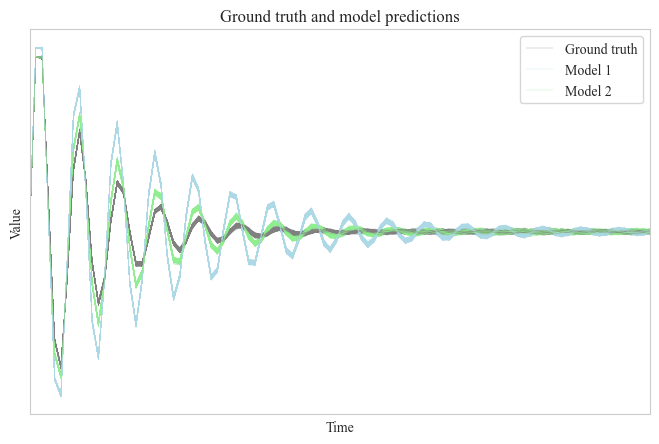

In [148]:
# Plot realizations of the ground truth and model predictions with different colors
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(n_samples):
    ax.plot(sim_time, ground_truth[i, :], linewidth=0.2, color='gray', label='Ground truth')
    ax.plot(sim_time, model_predictions1[i, :], linewidth=0.2, color='lightblue', label='Model 1')
    ax.plot(sim_time, model_predictions2[i, :], linewidth=0.2, color='lightgreen', label='Model 2')

ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Ground truth and model predictions')
ax.set_xlim([0, sim_time[-1]])

# Add the legend for the different lines, only first three
ax.legend(['Ground truth', 'Model 1', 'Model 2'])

# Modify the ticks. First, x-axis
x_pos = []
x_label = []
ax.set_xticks(x_pos)
ax.set_xticklabels(x_label)

# Second, y-axis
y_pos = []
y_label = []
ax.set_yticks(y_pos)
ax.set_yticklabels(y_label)
None

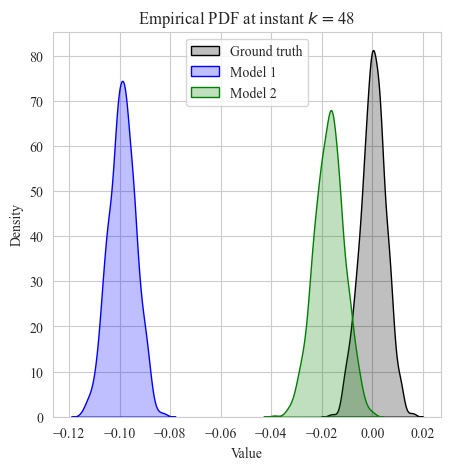

In [160]:
# Select some time and plot the distributions
k = 48

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.kdeplot(ground_truth[:, k], color='black', linewidth=1, label='Ground truth', fill=True)
sns.kdeplot(model_predictions1[:, k], color='blue', linewidth=1, label='Model 1', fill=True)
sns.kdeplot(model_predictions2[:, k], color='green', linewidth=1, label='Model 2', fill=True)

ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.set_title(f'Empirical PDF at instant $k=${k}')
ax.legend()

None

<Axes: ylabel='Density'>

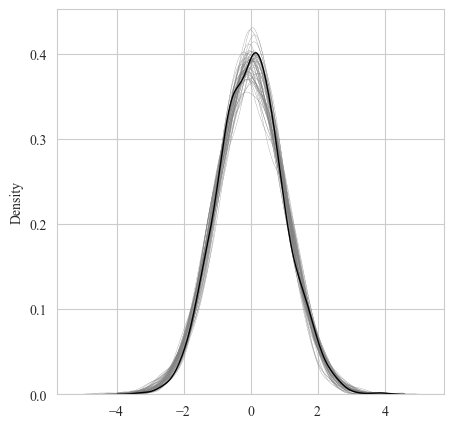

In [38]:
# Calculate the lack of fit for fidelity at each time step
from greyboxmodels.voi.metrics.lack_of_fit import lack_of_fit

lack_of_fit1 = lack_of_fit(ground_truth, model_predictions1)
lack_of_fit2 = lack_of_fit(ground_truth, model_predictions2)